# SAXS&WAXS pipeline for data reduction, e.g.,  to convert 2D scattering patterns to 1D curves (q-Iq, ang-Iang) etc.


## Overview

* Setup: load packages/setup path
* Load calibration h5 file (genreated by calibration pipeline) to load Mask and beamline parameters
* Check one data and convert scattering data to q-phi map, q-Iq, ang-Iang
* Find the interested dataset and do batch reduction
* Produce images (png format)
* Export results to a hdf file 
 

### DEV
* V0: Initialize the pipeline (2019/10/26 by YG yuzhang@bnl.gov)
* V1: Develop the pyScatt package and correct  a bug in qphi analysis (2019/11/8 by YG yuzhang@bnl.gov)


 

## TODLIST
* 1): Put codes into a package

# Load Package

In [1]:
%matplotlib notebook
from pyScatt.packages import *
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
 

# Setup Paths

In [2]:
####
inDir = '/home/yuzhang/XScattering/CFN_SAXS_Template/Data/'
outDir = '/home/yuzhang/XScattering/CFN_SAXS_Template/Results/'

# Load Seup_pargs and Mask

In [3]:
md_saxs = load_h5_as_dict( outDir + 'SAXS_setup_pargs_test.h5' )
setup_pargs = md_saxs['md']
mask = md_saxs['mask'] 
setup_pargs['outDir'] = outDir
setup_pargs['inDir'] = inDir
center = setup_pargs['center']
dpix = setup_pargs['dpix']
lambda_ = setup_pargs['lambda_']
Ldet = setup_pargs['Ldet']
cx,cy=center  


/home/yuzhang/Repos/pyScatt/pyScatt/IO.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if md.attrs[key] == 'None':


In [4]:
setup_pargs

{'Ldet': 5065.0,
 'center': array([605, 753]),
 'dpix': 0.17200000000000001,
 'exposuretime': 0.1,
 'lambda_': 0.9184,
 'path': '/home/yuzhang/XScattering/CFN_SAXS_Template/Results/',
 'timeperframe': 0.1,
 'uid': 'AgBH_cali_13.5kev_x-17.000_y-2.170_5.00s_2608571_saxs.tiff',
 'outDir': '/home/yuzhang/XScattering/CFN_SAXS_Template/Results/',
 'inDir': '/home/yuzhang/XScattering/CFN_SAXS_Template/Data/'}

<IPython.core.display.Javascript object>


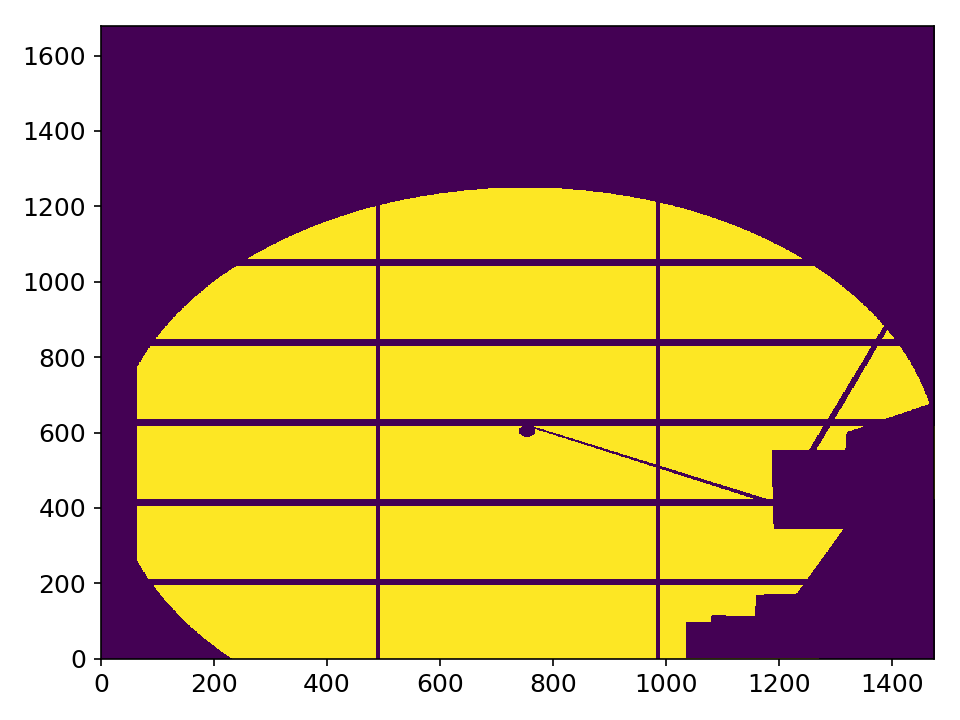

In [5]:
show_img(mask, show_colorbar=False)

# Check Filenames in inDir

In [6]:
tifs = ls_dir( inDir , have_list=['.tiff'], exclude_list=[ 'waxs' ])
print(len(tifs))
tifs

9


array(['f3b03825-edfa-43f3-b333_000003.tiff',
       'f3b03825-edfa-43f3-b333_000002.tiff',
       'AgBH_cali_13.5kev_x-17.000_y-2.170_1.00s_2608570_saxs.tiff',
       'AgBH_cali_13.5kev_x-17.000_y-2.170_5.00s_2608571_saxs.tiff',
       'FL_1024Morn_F1_x0.100_y0.150_0.10s_2605949_saxs.tiff',
       'FL_1026Morn_F2_x0.000_y0.000_1.00s_2607309_saxs.tiff',
       'FL_1024Morn_F1_x0.100_y0.150_0.10s_2605950_saxs.tiff',
       'f3b03825-edfa-43f3-b333_000001.tiff',
       'FL_1024Ngt_10nmSP_Form_Factor_x-0.900_y-0.400_5.00s_2606361_saxs.tiff'],
      dtype='<U69')

# Setup Data Analysis Parameters Using One Data

In [7]:
fp = 'f3b03825-edfa-43f3-b333_000002.tiff'

In [8]:
img_ = get_cms_img( fp, inDir ) 
img = img_ * mask
setup_pargs['uid'] = fp[:]

In [9]:
img_zoom_half_width = 300  # define a rectangle region of the image with 2*cw width around beam center for plot. 
                       # only this region will be saved to the exported h5 file


<IPython.core.display.Javascript object>


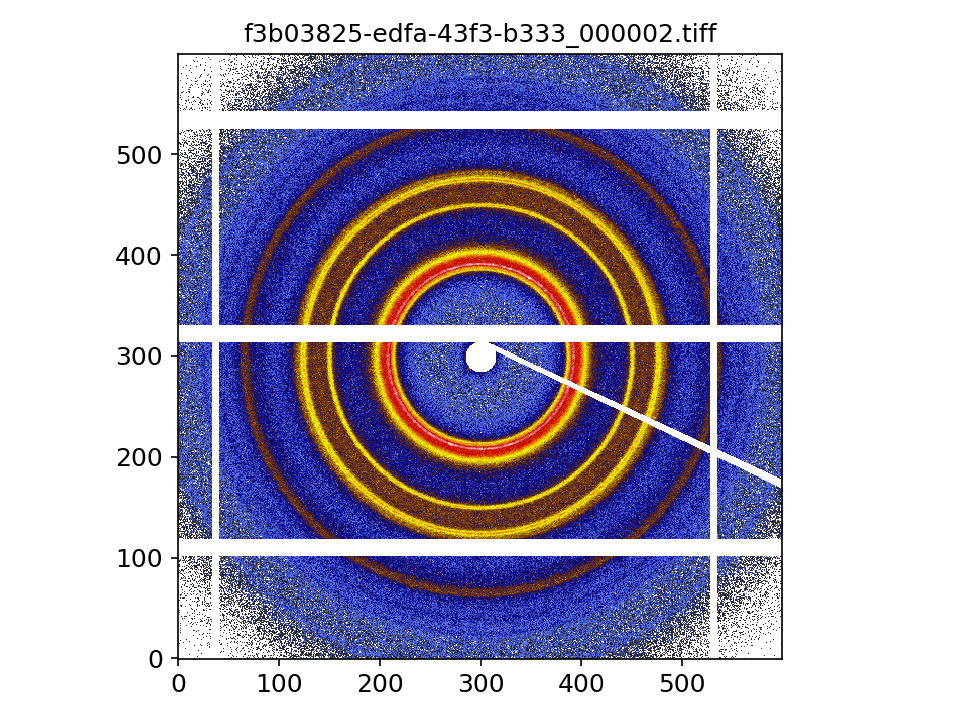

In [10]:
show_img( img[cx-img_zoom_half_width:cx+img_zoom_half_width,cy-img_zoom_half_width:cy+img_zoom_half_width], 
         logs=True, aspect= 1, cmap=  cmap_hdr_goldish, image_name= fp[:], save=True,path=outDir)

## Do Circular Average

In [11]:

print_dict( setup_pargs )

Ldet--> 5065.0
center--> [605 753]
dpix--> 0.17200000000000001
exposuretime--> 0.1
lambda_--> 0.9184
path--> /home/yuzhang/XScattering/CFN_SAXS_Template/Results/
timeperframe--> 0.1
uid--> f3b03825-edfa-43f3-b333_000002.tiff
outDir--> /home/yuzhang/XScattering/CFN_SAXS_Template/Results/
inDir--> /home/yuzhang/XScattering/CFN_SAXS_Template/Data/


In [12]:
qp0, iq0, q0 = get_circular_average( img, mask , pargs=setup_pargs,save= True  )

<IPython.core.display.Javascript object>


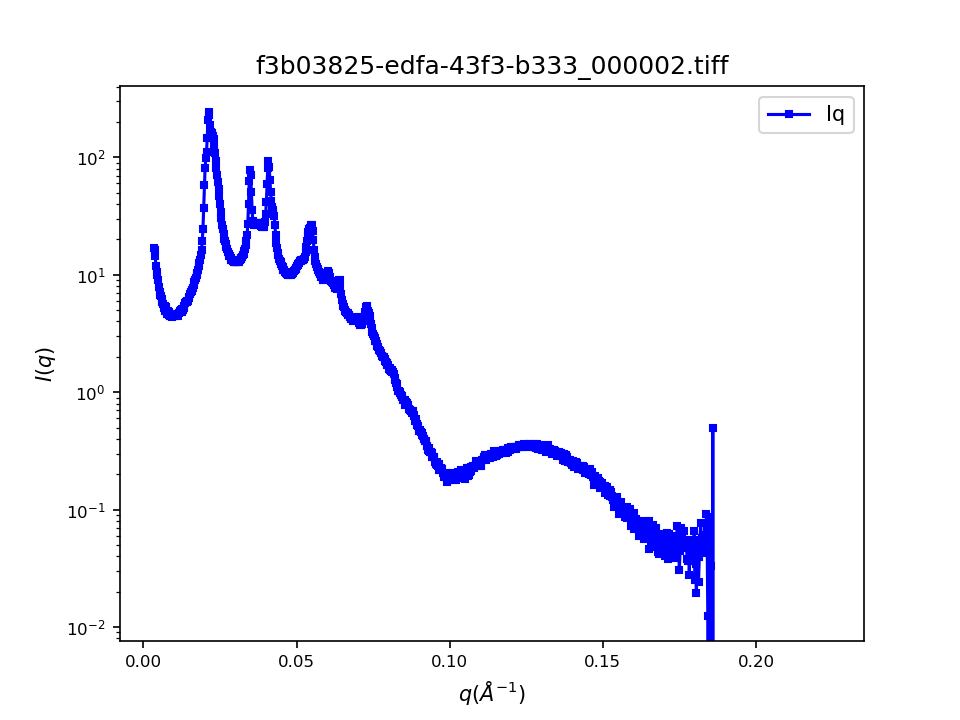

Text(0, 0.5, '$I(q)$')

In [13]:
fig,ax=plt.subplots()
plot1D( x = q0, y = iq0, yerr= None, logy= True, #xlim=[0.002, 0.12],  
       c='b', m = 's',legend='Iq', markersize= 3,  ax=ax,)  
ax.set_title (  fp[:])
ax.set_xlabel (r'$q (\AA^{-1})$')
ax.set_ylabel ( r'$I(q)$' )

## Convert this image to q-phi plot

* Define the parameters for bin numbe of q and  phi,  bin range of q and phi

In [14]:
bin_num_q = 500  
bin_num_phi =  180
bin_q_range = [0.001, 0.12] 
bin_phi_range = [-180, 180]

* Get q-map and phi-map for remesh 

In [15]:
bins = bin_num_q, bin_num_phi
qang_range=  [ bin_q_range,  bin_phi_range ] 
q_map_ = utils.radial_grid( center, img.shape, pixel_size= [dpix,dpix] )
q_map =  utils.twotheta_to_q( utils.radius_to_twotheta(Ldet, q_map_),lambda_ )
phi_map = np.degrees( angle_grid(center, img.shape,) )

* Do conversion

In [16]:
sqphi,  qs,  phis = qphiavg(img, q_map=q_map, phi_map=phi_map, mask=mask, bins= bins,
        origin= center, range=qang_range, statistic='mean') 
sqphim,  qsm,  phism = qphiavg( mask, q_map=q_map, phi_map=phi_map, mask=mask, bins= bins,
        origin= center, range=qang_range, statistic='mean') 
ma  = np.isnan( sqphim ) 

/home/yuzhang/conda_envs/pyScattering/lib/python3.7/site-packages/skbeam/core/accumulators/binned_statistic.py:349: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.result = self.result[core]


* plot qphi remeshed image

<IPython.core.display.Javascript object>


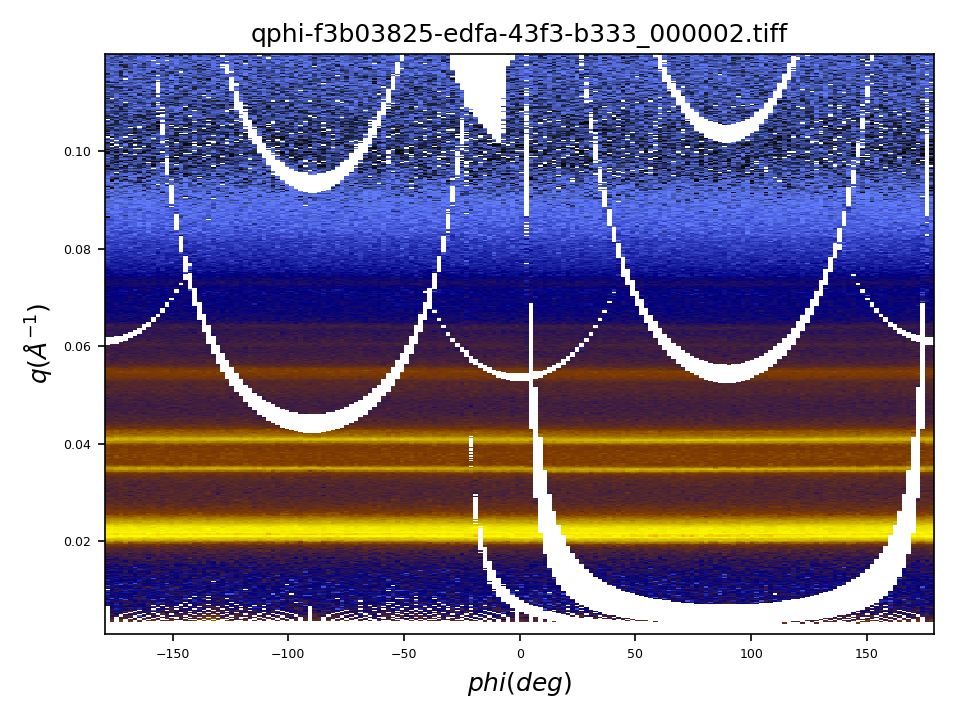

In [17]:
show_img(  sqphi,  logs=True, aspect= None, cmap=  cmap_hdr_goldish,#cmap_hdr_albula, 
           vmin=0.01,vmax=1e4, 
           tick_size=6, colorbar_fontsize=6, lab_fontsize=12,
           show_ticks= True, title_size=8, 
           extent=[phis[0], phis[-1], qs[0], qs[-1]], 
           xlabel=r'$phi (deg)$', ylabel=  r'$q (\AA^{-1})$',
           image_name= 'qphi-' + fp, save= False, path=outDir  )   

## Get q-Iq based on the converted qphi 

* average all angles if not given the angle cut position (acut_pos and acut_wid)

In [21]:
acut_pos = None #angle cut position, if None, do all angle average, otherwise, do avaerge around the cut with awid
acut_pos=-50  #in degree
acut_wid=5    #in degree




In [22]:
if acut_pos is None:
    qsb, iqsb  = get_iq_from_sqphi( qs, sqphi,  mask= ma) 
else:
    acut1,acut2 = find_index( phis, acut_pos - acut_wid ), find_index( phis, acut_pos + acut_wid )    
    qsb, iqsb  =  get_iq_from_sqphi( qs, sqphi[:,acut1:acut2],  mask= ma[:,acut1:acut2]) 
    

<IPython.core.display.Javascript object>


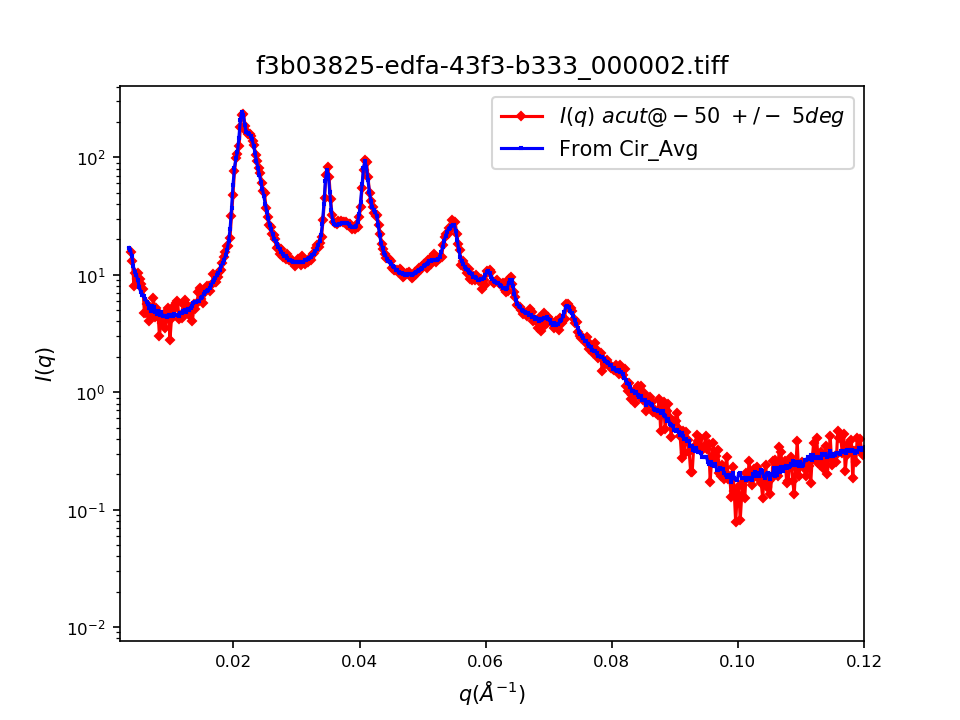

Text(0, 0.5, '$I(q)$')

In [23]:
fig,ax=plt.subplots()
if acut_pos is None:
    legend='From QPhi_Map'
else:
    legend= r'$I(q)\ acut@%s \ +/-\   %s deg$'%(acut_pos, acut_wid)
plot1D( x = qsb, y = iqsb, yerr= None, logy= True, xlim=[0.002, 0.12],  ax=ax, legend=legend,
       c='r', m = 'D',   markersize= 3)
plot1D( x = q0, y = iq0, yerr= None, logy= True, xlim=[0.002, 0.12],  ax=ax, legend='From Cir_Avg',
       c='b', m = 's',   markersize= 1)
#ax.vlines( qpeak, 0, iqsb[qind_max]*1.5, linestyle='--'  )
ax.set_title (  fp[:])
ax.set_xlabel (r'$q (\AA^{-1})$')
ax.set_ylabel ( r'$I(q)$' )

## Get ang-Iang based on the converted qphi 

* average around the Iq peak position if not given the q-position (qcut_pos and qcut_wid) 

In [20]:
qcut_pos = None #angle cut position, if None, do all angle average, otherwise, do avaerge around the cut with awid
qcut_pos= 0.022  #in angstron
qcut_wid = 5    #in pixel
search_qmax_range = [0.01, 0.1 ]




In [24]:
if qcut_pos is None:
    q1, q2 = find_index( qsb, search_qmax_range[0]  ),  find_index( qsb,search_qmax_range[1]  )
    qind_max = np.argmax( iqsb[q1 : q2 ] ) + q1
    qpeak = qsb[ qind_max  ]    
else:
    qpeak = qcut_pos
qind_max_qs = find_index( qs, qpeak)    
print( qpeak,   qind_max_qs )

0.022 88


<IPython.core.display.Javascript object>


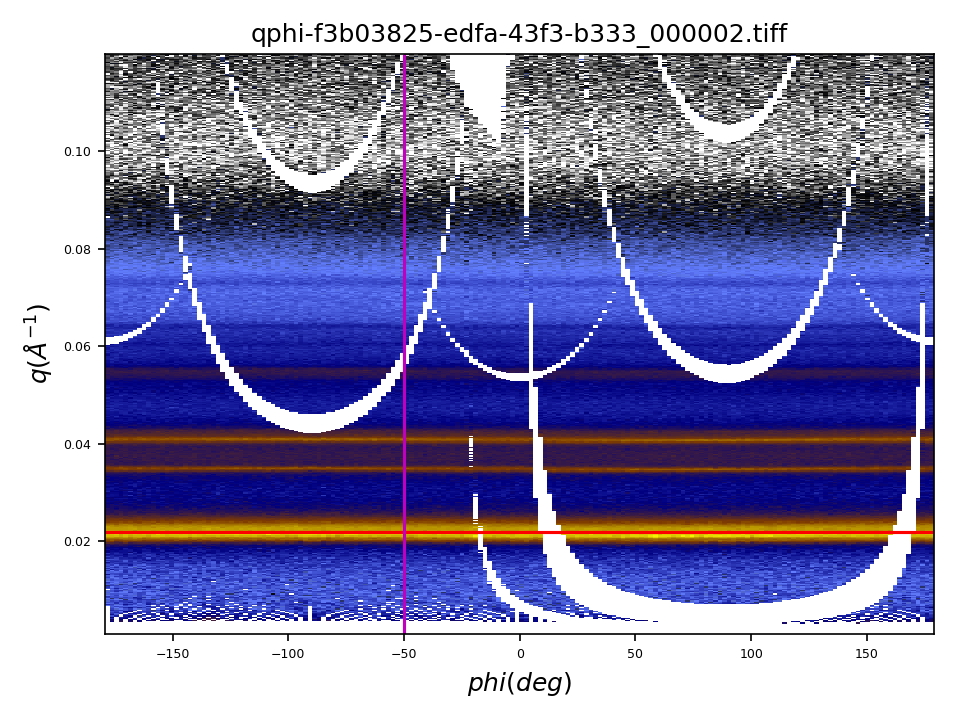

In [25]:
fig, ax = plt.subplots()
show_img(  sqphi,
           ax=[fig,ax], logs=True, aspect= None, cmap=  cmap_hdr_goldish,
           vmin= 1e-1,vmax=1e4,  
           tick_size=6, colorbar_fontsize=6, lab_fontsize=12,
           show_ticks= True, title_size=8,            
           extent=[phis[0], phis[-1], qs[0], qs[-1]], 
           xlabel=r'$phi (deg)$', ylabel=  r'$q (\AA^{-1})$',
           image_name= 'qphi-' + fp )  
ax.hlines(   qpeak, phis[0], phis[-1], colors='r'  )
if acut_pos is not None:
    ax.vlines(   acut_pos, qs[0], qs[-1], colors='m'  )


In [28]:
phisb, iphib  = get_phi_from_sqphi( phis, sqphi[ qind_max_qs - qcut_wid:  qind_max_qs + qcut_wid], 
                                   mask= ma[ qind_max_qs - qcut_wid:  qind_max_qs + qcut_wid]) 

<IPython.core.display.Javascript object>


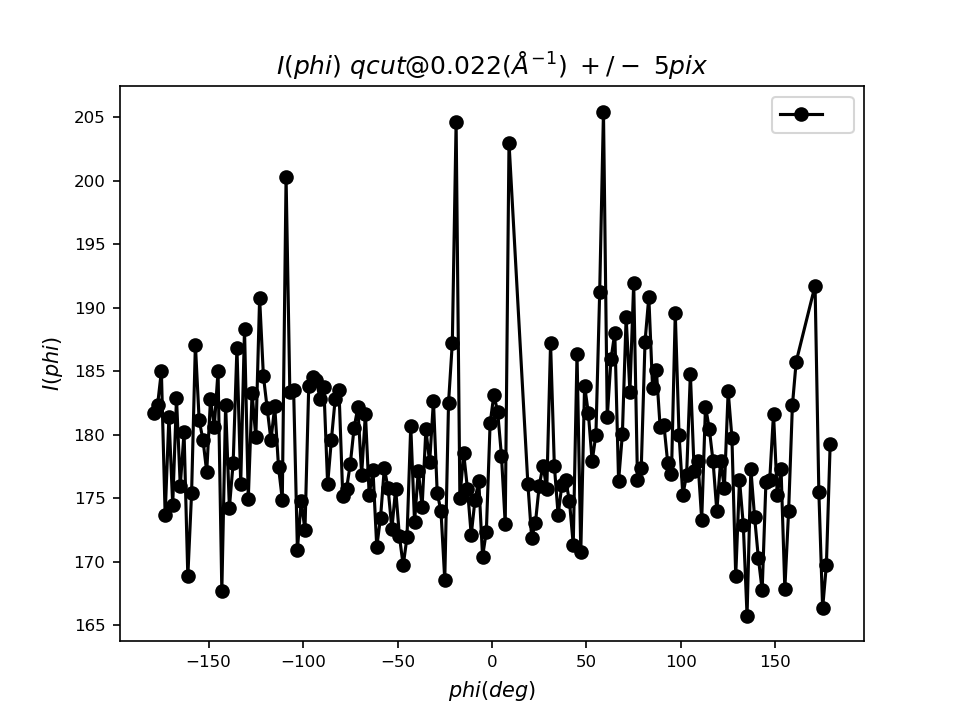

Text(0.5, 1.0, '$I(phi)\\ qcut@0.022 (\\AA^{-1}) \\ +/-\\   5 pix$')

In [29]:
fig,ax=plt.subplots()
plot1D(  x=phisb, y=iphib, m='o', c='k', ax=ax,  )
ax.set_xlabel (r'$phi (deg)$')
ax.set_ylabel ( r'$I(phi)$' )  
ax.set_title( r'$I(phi)\ qcut@%s (\AA^{-1}) \ +/-\   %s pix$'%(qpeak, qcut_wid) )

In [31]:
setup_pargs

{'Ldet': 5065.0,
 'center': array([605, 753]),
 'dpix': 0.17200000000000001,
 'exposuretime': 0.1,
 'lambda_': 0.9184,
 'path': '/home/yuzhang/XScattering/CFN_SAXS_Template/Results/',
 'timeperframe': 0.1,
 'uid': 'f3b03825-edfa-43f3-b333_000002.tiff',
 'outDir': '/home/yuzhang/XScattering/CFN_SAXS_Template/Results/',
 'inDir': '/home/yuzhang/XScattering/CFN_SAXS_Template/Data/'}

In [32]:
#%run -i ~/pyScatt_link/pyScatt/saxs.py

# Define the parameter for papermill

In [33]:
uid_list =  [ 'f3b03825-edfa-43f3-b333_000001.tiff'   ]

# Run reduction using the parameters defined above

In [41]:
data_reduction_pargs={}
data_reduction_pargs['img_zoom_half_width'] = img_zoom_half_width
data_reduction_pargs['bin_num_q'] = bin_num_q
data_reduction_pargs['bin_num_phi']=bin_num_phi
data_reduction_pargs['bin_q_range']=bin_q_range
data_reduction_pargs['bin_phi_range']=bin_phi_range
data_reduction_pargs['acut_pos'] =  acut_pos
data_reduction_pargs['acut_wid'] = acut_wid 
data_reduction_pargs['qcut_pos'] = qcut_pos
data_reduction_pargs['qcut_wid'] =qcut_wid
data_reduction_pargs['search_qmax_range'] = search_qmax_range
#data_reduction_pargs = None

0---> f3b03825-edfa-43f3-b333_000001.tiff
img_zoom_half_width 300
bin_num_q 500
bin_num_phi 180
bin_q_range [0.001, 0.12]
bin_phi_range [-180, 180]
acut_pos -50
acut_wid 5
qcut_pos 0.022
search_qmax_range [0.01, 0.1]
qcut_wid 5
The file: /home/yuzhang/XScattering/CFN_SAXS_Template/Results/f3b03825-edfa-43f3-b333_000001.tiff.h5 is deleted.
The results are exported as a h5 file: /home/yuzhang/XScattering/CFN_SAXS_Template/Results/f3b03825-edfa-43f3-b333_000001.tiff.h5.


<IPython.core.display.Javascript object>


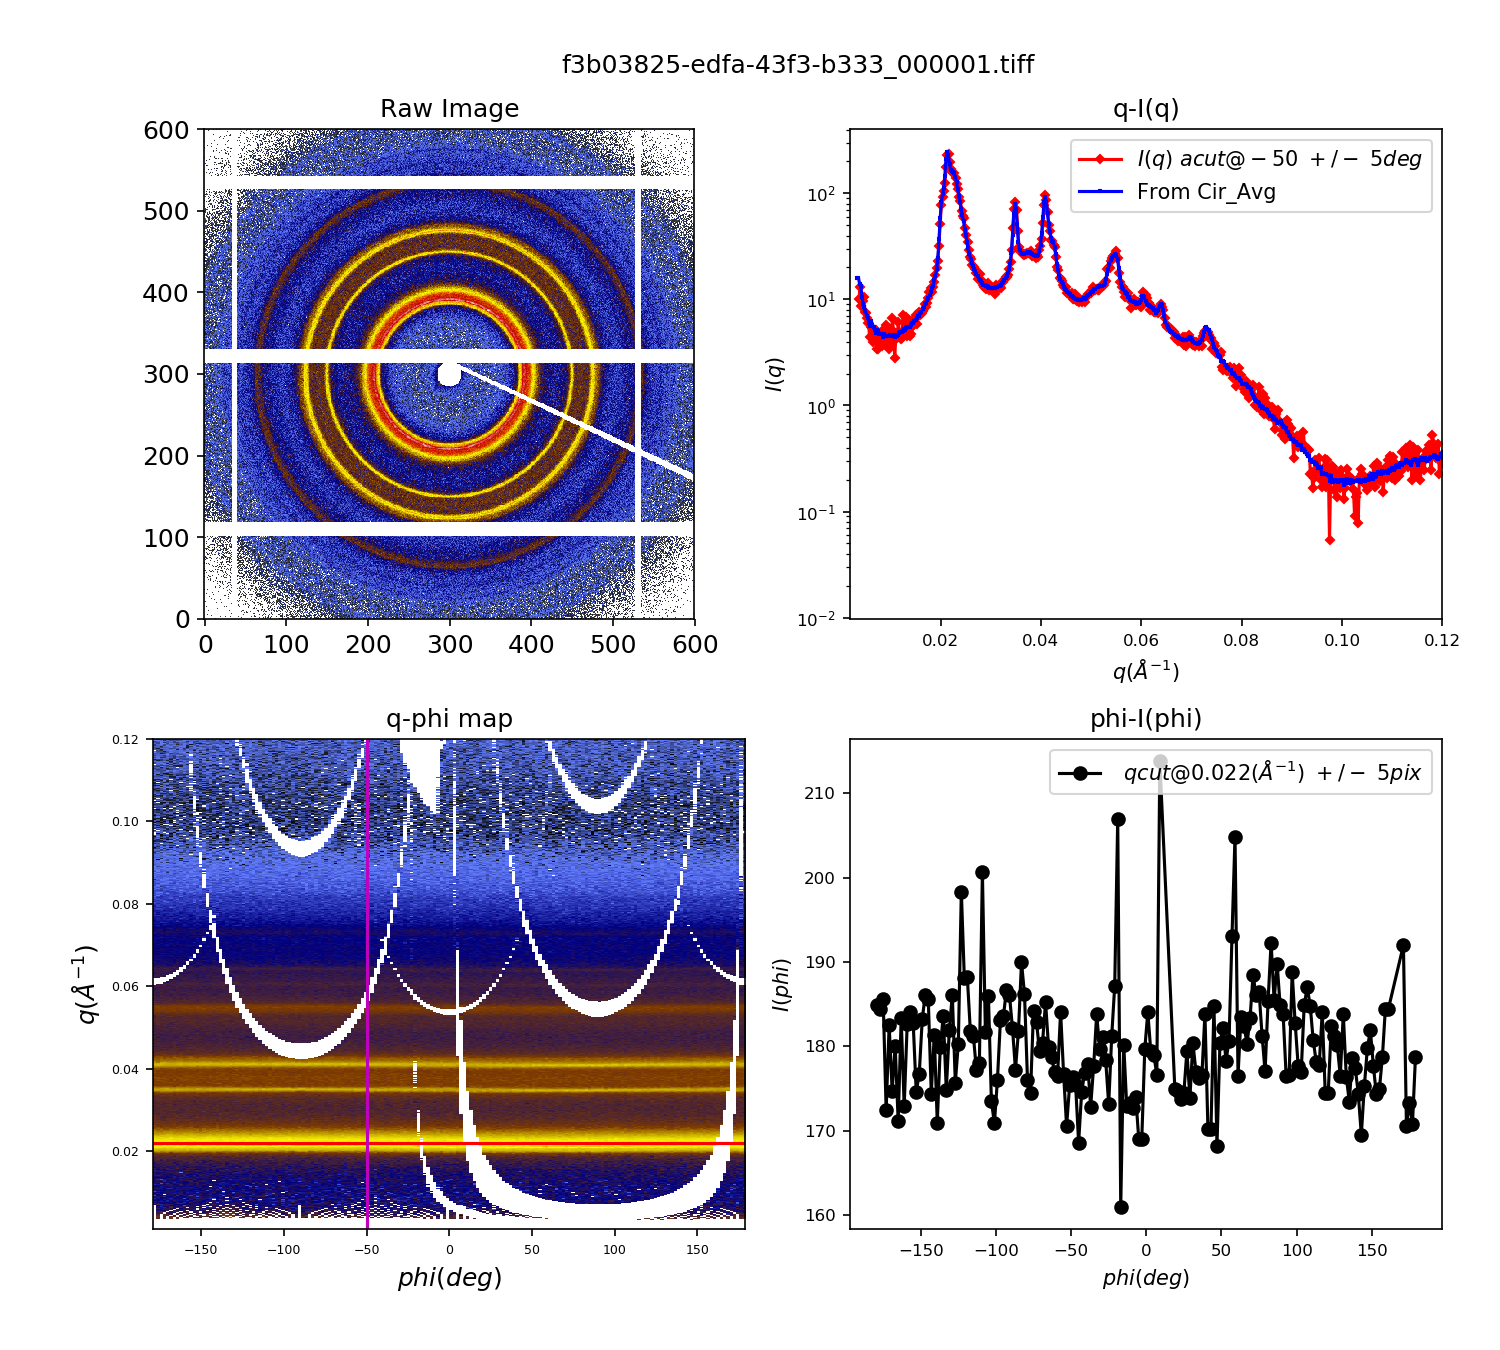

Total time: 1.975 sec


In [42]:
t0 = time.time() 
for i, fp in enumerate( uid_list ):     
    print('%s---> %s'%(i, fp) )    
    #try:
    if True:    
        img = get_cms_img( fp, inDir ) * mask
        img = np.abs(img)
        setup_pargs['uid'] = fp
        res = Run_SAXS_Data_Reduction( img, mask, setup_pargs,
                                      data_reduction_pargs = data_reduction_pargs, overwrite_h5=True ) 
        Plot_SAXS_Data_Reduction( res['md']['fout']  ) 
        
        #print(fout)
    #except:
    #    print('Something wrong with this data: %s'%fp) 
run_time( t0 )        

# The End